In [29]:
import os, sys, time, glob, random
# load yaml config
import yaml
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import numpy as np
from PIL import Image, ImageOps

from fit import lr_schedule, fit, TrainState, load_ckpt
from model.unetv3_light import UNetV3 as UNet


key = jax.random.PRNGKey(0)
cfg = yaml.safe_load(open("config.yaml"))
print(cfg)

# predict one image
def predict_one_image(state, img_path, cfg):
    # get ratio of the image
    img = Image.open(img_path).convert("RGB")
    w, h = img.size
    ratio = w / h
    
    # if ratio is equal to 1, then resize to cfg["img_size"]
    if ratio == 1:
        img = img.resize((cfg["img_size"], cfg["img_size"]))
    else:
        # keep the longer side to cfg["img_size"] and keep the ratio
        if w > h:
            img = img.resize((cfg["img_size"], int(cfg["img_size"] / ratio)))
        else:
            img = img.resize((int(cfg["img_size"] * ratio), cfg["img_size"]))

    # padding to cfg["img_size"] centially
    w, h = img.size
    left = (cfg["img_size"] - w) // 2
    right = cfg["img_size"] - w - left
    top = (cfg["img_size"] - h) // 2
    bottom = cfg["img_size"] - h - top
    img = ImageOps.expand(img, border=(left, top, right, bottom), fill='black')

    img = jnp.array(img)
    img = jnp.expand_dims(img, axis=0) / 255.
    pred = state.apply_fn({
        'params': state.params,
        'batch_stats': state.batch_stats,
    }, img, mutable=['batch_stats'], rngs={'dropout': key})
    return pred


{'img_size': 256, 'features': 16, 'batch_size': 8, 'lr': 0.003, 'epochs': 100, 'warmup': 5, 'ckpt': 'checkpoints/checkpoint_100', 'focal_loss': {'weight': 1.0}, 'dice_bce_loss': {'weight': 1.0}}


In [30]:
model = UNet(cfg["features"], training=False)
var = model.init(key, jnp.zeros((1, cfg["img_size"], cfg["img_size"], 3)))
params = var['params']
batch_stats = var['batch_stats']

state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    batch_stats=batch_stats,
    tx=optax.inject_hyperparams(optax.nadam)(0),
)

In [31]:
# single test for load via given folder path
ckpt_path = 'checkpoints'
state = load_ckpt(state, ckpt_path)

# predict one image
img_path = '/Users/haoyu/Desktop/world license plate builder/output/image/*.png'
img_path = "debug/*.jpg"

img_path = random.choice(glob.glob(img_path))
(hmap, pixs, ord_), _ = predict_one_image(state, img_path, cfg)

==             Loading ckpt from checkpoints              ==


In [32]:
pixs = jax.nn.sigmoid(pixs)
# ord_ = jax.nn.sigmoid(ord_)
debug_ord = ord_

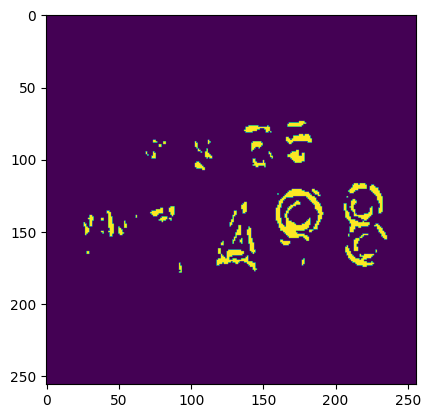

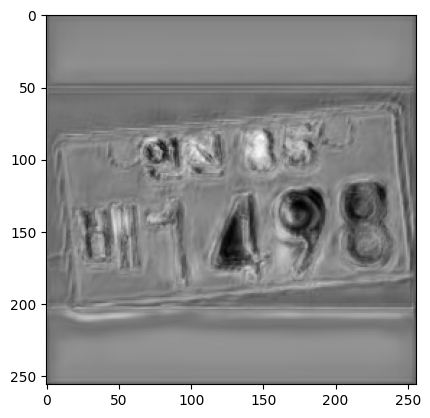

In [33]:
from matplotlib import pyplot as plt

pixs = jnp.where(pixs > 0.5, 1, 0)
plt.imshow(pixs[0])
plt.show()

hmap = nn.sigmoid(hmap)[0]
# keep > .5
# plt.imshow(jnp.where(hmap > 0.1, 1, 0))
plt.imshow(hmap, cmap="gray")
plt.show()

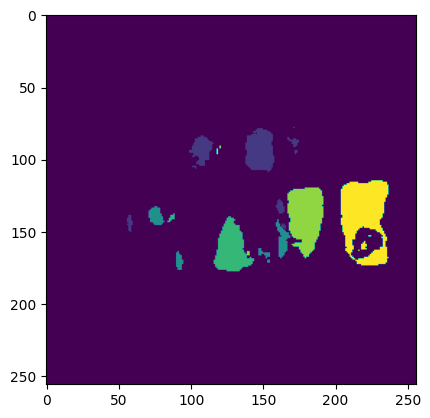

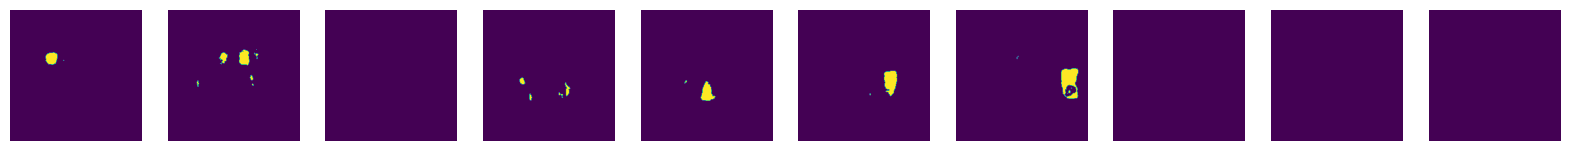

In [34]:
# show ord_
ord_ = jnp.where(ord_[0] > 0.5, 1, 0)
ord_ = jnp.argmax(ord_, axis=-1)
plt.imshow(ord_)
plt.show()

n = 10
scale = 2
fig, ax = plt.subplots(1, n, figsize=(n*scale, scale))
for i in range(n):
    tmp = debug_ord[0, :, :, i]
    tmp = jnp.where(tmp > 0.5, 1, 0)
    ax[i].imshow(tmp)
    ax[i].axis('off')

plt.show()


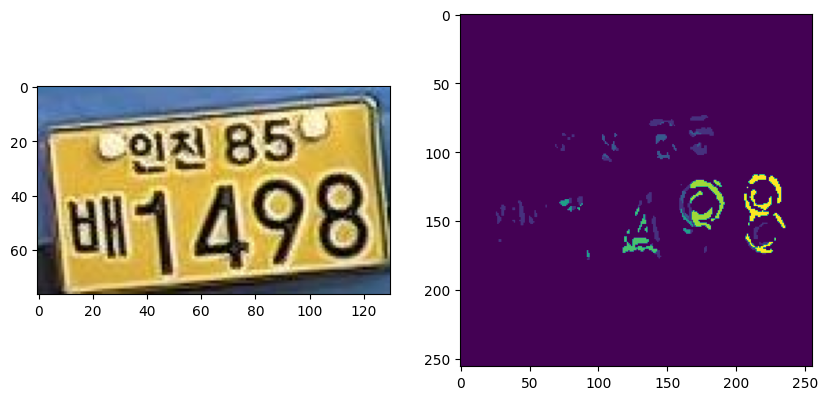

In [35]:
ord_ = jnp.where(ord_ > 0.5, ord_, 0)
ord_ += 1
res = ord_ * np.squeeze(pixs)

# show original image and predicted result
img = Image.open(img_path).convert("RGB")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(res)
plt.show()